In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    mutual_info_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [13]:
df = pd.read_csv(
    '/Users/yanqingsong/Documents/mypythonscript/practice scripts/ml zoomcamp/machine-learning-zoomcamp-homework/07-mid-project/heart_failure_clinical_records_dataset.csv'
)

# Data preparation

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [15]:
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Use 12 clinical features to predict death_event:

- `age`: age of the patient (int, years)
- `anaemia`: decrease of red blood cells or hemoglobin (boolean)
- `creatinine_phosphokinase`  (CPK): level of the CPK enzyme in the blood (int, mcg/L)
- `diabetes`: if the patient has diabetes (boolean)
- `ejection_fraction`: percentage of blood leaving the heart at each contraction  (int, percentage)
- `high_blood_pressure`: if the patient has hypertension (boolean)
- `platelets`: platelets in the blood (float, kiloplatelets/mL)
- `serum_creatinine`: level of serum creatinine in the blood (float, mg/dL)
- `serum_sodium`: level of serum sodium in the blood (int, mEq/L)
- `sex`: woman or man (binary, 0:women, 1:men)
- `smoking`: if the patient smokes or not (boolean)
- `time`: follow-up period (int, days)
- `death_event`[target]: if the patient died during the follow-up period (boolean)

In [16]:
df.head(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1,10,1


In [17]:
df['age'] = df['age'].astype(int)
df.columns = df.columns.str.lower()

In [18]:
for col in ['anaemia', 'diabetes', 'high_blood_pressure', 'smoking', 'death_event']:
    df[col] = df[col] == 1
df['sex'] = df['sex'].map({0: 'woman', 1: 'man'})
df.dtypes


age                           int64
anaemia                        bool
creatinine_phosphokinase      int64
diabetes                       bool
ejection_fraction             int64
high_blood_pressure            bool
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                          object
smoking                        bool
time                          int64
death_event                    bool
dtype: object

# EDA

In [19]:
df.describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000
mean,60.829431,581.839465,38.083612,263358.029264,1.39388,136.625418,130.260870
std,11.894997,970.287881,11.834841,97804.236869,1.03451,4.412477,77.614208
min,40.000000,23.000000,14.000000,25100.000000,0.50000,113.000000,4.000000
25%,51.000000,116.500000,30.000000,212500.000000,0.90000,134.000000,73.000000
50%,60.000000,250.000000,38.000000,262000.000000,1.10000,137.000000,115.000000
75%,70.000000,582.000000,45.000000,303500.000000,1.40000,140.000000,203.000000
max,95.000000,7861.000000,80.000000,850000.000000,9.40000,148.000000,285.000000


split dataset 60%/20%/20%

In [21]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df.drop(columns='death_event'),
    (df['death_event']).astype(int),
    test_size=0.2,
    random_state=9,
)
X_train_full.shape, y_train_full.shape

((239, 12), (239,))

Numeric features:

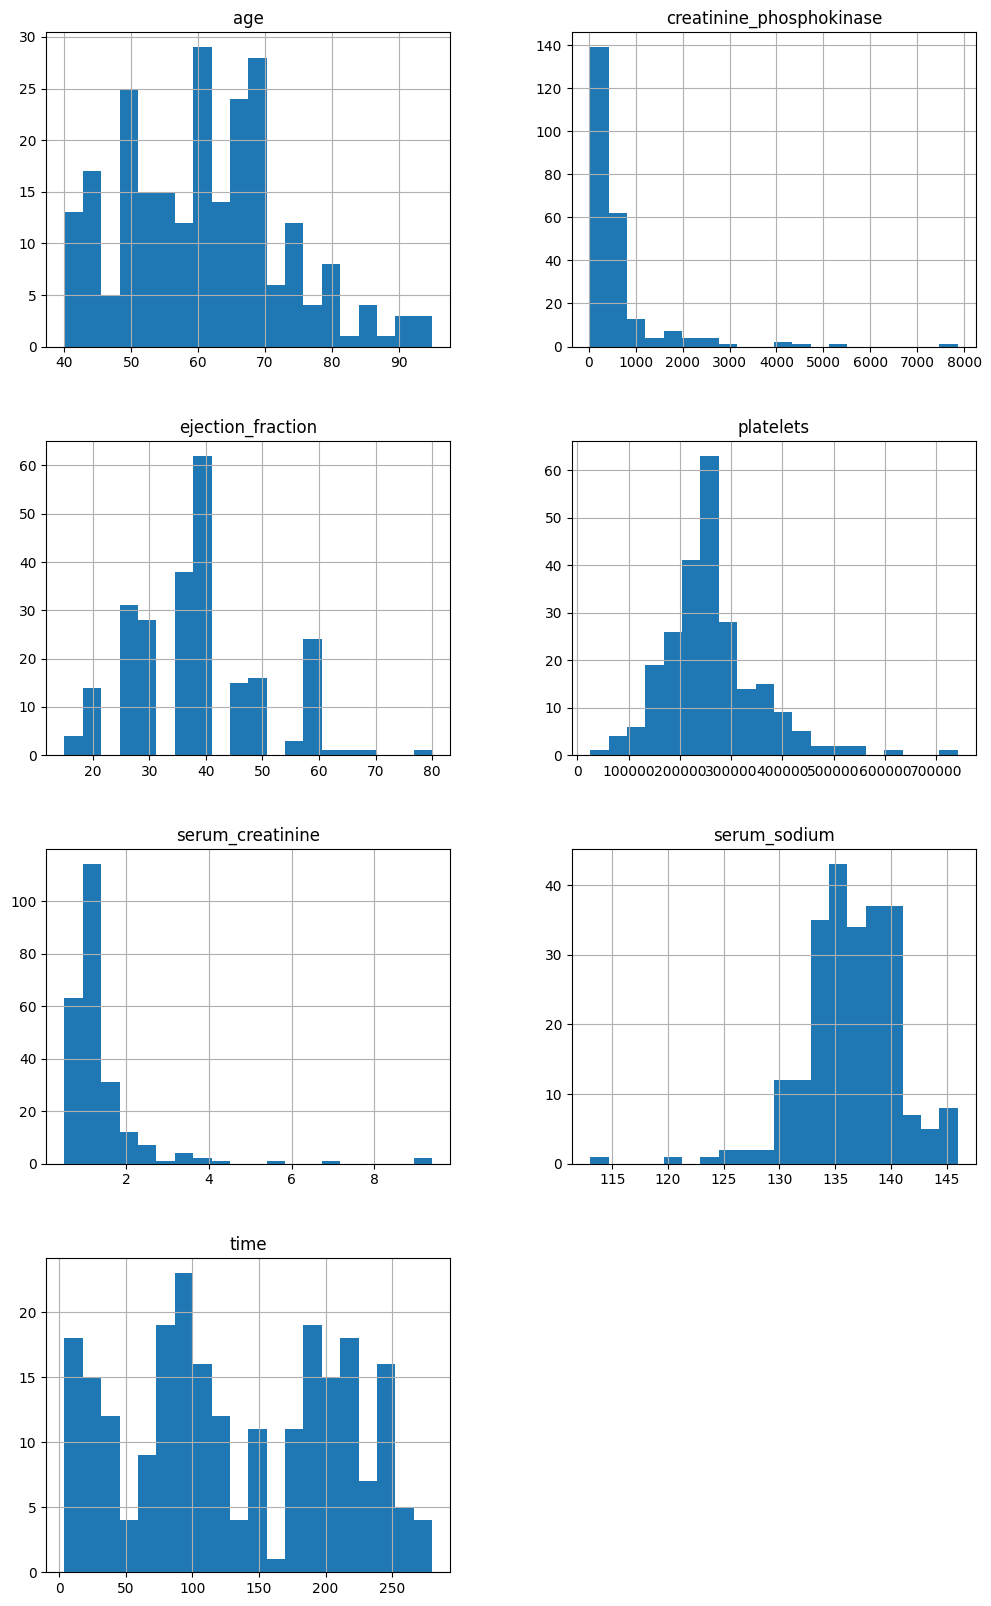

In [11]:
X_train_num = X_train_full.select_dtypes(include='number')
X_train_num.hist(figsize=(12, 20), bins=20, layout=(4, 2))
plt.show()

Features reatinine_phosphokinase and serum_creatinine are right skewed, though the tails are not very long. The other features are more symmetric, however, they do not seem quite normal distribution. Can use statiscal methods to verify this.



In [12]:
X_train_full_cat = X_train_full.select_dtypes(exclude='number')
X_train_full_cat.apply(mutual_info_score, args=(y_train_full,)).sort_values(
    ascending=False
).to_frame(name='mutual_info_score')


,mutual_info_score
high_blood_pressure,0.005749
smoking,0.001161
anaemia,0.000923
diabetes,0.000389
sex,0.000221


Weak correlation (abs<0.26) between numeric features

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
age,1.000,-0.116,0.052,-0.004,0.167,-0.042,-0.256
creatinine_phosphokinase,-0.116,1.000,0.002,0.023,-0.003,0.087,0.045
ejection_fraction,0.052,0.002,1.000,0.129,0.019,0.129,0.030
platelets,-0.004,0.023,0.129,1.000,-0.068,0.100,0.039
serum_creatinine,0.167,-0.003,0.019,-0.068,1.000,-0.133,-0.198
serum_sodium,-0.042,0.087,0.129,0.100,-0.133,1.000,0.088
time,-0.256,0.045,0.030,0.039,-0.198,0.088,1.000


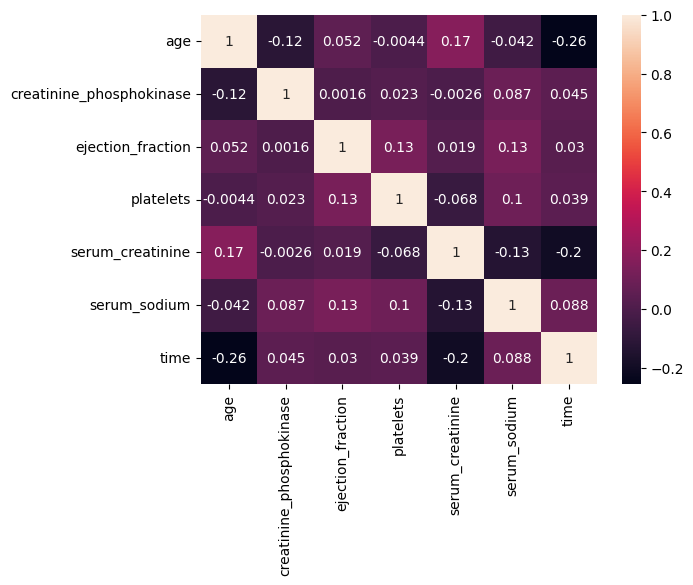

In [13]:
sns.heatmap(X_train_num.corr(), annot=True)
X_train_num.corr().round(3)

In [14]:
X_train_num = X_train_full.select_dtypes('number')
X_train_num.corrwith(y_train_full).sort_values(key=abs, ascending=False).to_frame(
    name='correlation'
)

,correlation
time,-0.532724
serum_creatinine,0.347816
ejection_fraction,-0.268134
age,0.256355
serum_sodium,-0.179449
platelets,-0.084287
creatinine_phosphokinase,-0.025614


In [15]:
y_train_full.value_counts(normalize=True)


death_event
0    0.661088
1    0.338912
Name: proportion, dtype: float64

This is an imbalance dataset. Therefore, auc, f1_score, precision and recall are selected as the evaluation metrics apart from accurary

# Logistic regression model

In [103]:
n_splits = 5
scores = []
lr_models = {}
for C in [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 100]:
    kf = KFold(n_splits, shuffle=True, random_state=7)
    for train_idx, val_idx in kf.split(X_train_full):
        X_train = X_train_full.iloc[train_idx]
        X_val = X_train_full.iloc[val_idx]
        y_train = y_train_full.iloc[train_idx]
        y_val = y_train_full.iloc[val_idx]

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(X_train.to_dict(orient='records'))
        X_val = dv.transform(X_val.to_dict(orient='records'))

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        lr_model = LogisticRegression(C=C, max_iter=1000)
        lr_model.fit(X_train, y_train)
        lr_models[C] = lr_model
        for d, x, y in zip(['train', 'val'], [X_train, X_val], [y_train, y_val]):
            y_score = lr_model.predict_proba(x)[:, 1]
            y_pred = y_score >= 0.5
            auc = roc_auc_score(y, y_score)
            accuracy = accuracy_score(y, y_pred)
            precision = precision_score(y, y_pred, zero_division=0)
            recall = recall_score(y, y_pred)
            f1 = f1_score(y, y_pred)
            scores.append((C, d, accuracy, auc, precision, recall, f1))


In [17]:
lr_scores = pd.DataFrame(
    scores,
    columns=['C', 'type', 'accuracy', 'auc', 'precision', 'recall', 'f1'],
)

lr_result = lr_scores.groupby(['C', 'type']).mean().round(3)
lr_result

accuracy    auc  precision  recall     f1
C        type                                            
0.0001   train     0.661  0.889      0.000   0.000  0.000
         val       0.661  0.861      0.000   0.000  0.000
0.0010   train     0.661  0.891      0.000   0.000  0.000
         val       0.661  0.864      0.000   0.000  0.000
0.0100   train     0.743  0.899      0.951   0.252  0.398
         val       0.740  0.872      0.967   0.253  0.391
0.1000   train     0.839  0.905      0.817   0.679  0.741
         val       0.824  0.875      0.837   0.628  0.704
1.0000   train     0.837  0.907      0.791   0.707  0.746
         val       0.820  0.879      0.784   0.676  0.718
5.0000   train     0.841  0.907      0.793   0.719  0.754
         val       0.815  0.878      0.766   0.689  0.718
10.0000  train     0.841  0.907      0.793   0.719  0.754
         val       0.815  0.877      0.766   0.689  0.718
100.0000 train     0.840  0.907      0.790   0.719  0.753
         val       0.815  0.877      0.766   0.689  0.718

We get the best auc and f1_score, and reasonably good accuracy, precision and recall at c=1.0. 

In [18]:
lr_result.query('type=="val"').sort_values('auc', ascending=False)

,,accuracy,auc,precision,recall,f1
C,type,,,,,
1.0000,val,0.820,0.879,0.784,0.676,0.718
5.0000,val,0.815,0.878,0.766,0.689,0.718
10.0000,val,0.815,0.877,0.766,0.689,0.718
100.0000,val,0.815,0.877,0.766,0.689,0.718
0.1000,val,0.824,0.875,0.837,0.628,0.704
0.0100,val,0.740,0.872,0.967,0.253,0.391
0.0010,val,0.661,0.864,0.000,0.000,0.000
0.0001,val,0.661,0.861,0.000,0.000,0.000


In [19]:
lr_result.query('type=="val"').sort_values('accuracy', ascending=False)

,,accuracy,auc,precision,recall,f1
C,type,,,,,
0.1000,val,0.824,0.875,0.837,0.628,0.704
1.0000,val,0.820,0.879,0.784,0.676,0.718
5.0000,val,0.815,0.878,0.766,0.689,0.718
10.0000,val,0.815,0.877,0.766,0.689,0.718
100.0000,val,0.815,0.877,0.766,0.689,0.718
0.0100,val,0.740,0.872,0.967,0.253,0.391
0.0001,val,0.661,0.861,0.000,0.000,0.000
0.0010,val,0.661,0.864,0.000,0.000,0.000


In [20]:
lr_result = lr_result.loc[(0.1, 'val')].to_frame(name='logistic_regression, C=0.1').T
lr_result

,accuracy,auc,precision,recall,f1
"logistic_regression, C=0.1",0.824,0.875,0.837,0.628,0.704


Feature importance with logistic regression model

In [127]:
logreg_feature_df = pd.DataFrame(
    {'feature': dv.feature_names_, 'logreg_coef': lr_models[0.1].coef_[0]}
).sort_values('logreg_coef', ascending=False, key=abs)
logreg_feature_df['logreg_rank'] = range(1, len(dv.feature_names_) + 1)
logreg_feature_df

,feature,logreg_coef,logreg_rank
12,time,-0.965273,1
4,ejection_fraction,-0.571806,2
7,serum_creatinine,0.541427,3
0,age,0.410151,4
8,serum_sodium,-0.151043,5
11,smoking,0.124916,6
2,creatinine_phosphokinase,-0.104251,7
1,anaemia,-0.099660,8
5,high_blood_pressure,-0.091672,9
9,sex=man,-0.091553,10


# Random forest

In [21]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=7
)
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train.to_dict(orient='records'))
X_val = dv.transform(X_val.to_dict(orient='records'))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [22]:
scores = []
for d in [1, 3, 5, 7, 10, 15, 20, 25]:
    for s in [1, 3, 5, 7, 10, 15, 20, 25]:
        rf_model = RandomForestClassifier(
            n_estimators=1,
            max_depth=d,
            min_samples_leaf=s,
            random_state=7,
            warm_start=True,
            n_jobs=-1,
        )
        for n in range(1, 201, 5):
            rf_model.n_estimators = n
            rf_model.fit(X_train, y_train)
            for t, x, y in zip(['train', 'val'], [X_train, X_val], [y_train, y_val]):
                y_score = rf_model.predict_proba(x)[:, 1]
                y_pred = y_score >= 0.5
                auc = roc_auc_score(y, y_score)
                accuracy = accuracy_score(y, y_pred)
                precision = precision_score(y, y_pred, zero_division=0)
                recall = recall_score(y, y_pred)
                f1 = f1_score(y, y_pred)
                scores.append((n, d, s, t, accuracy, auc, precision, recall, f1))


In [ ]:
rf_scores = pd.DataFrame(
    scores,
    columns=[
        'n_estimators',
        'max_depth',
        'min_samples_leaf',
        'type',
        'accuracy',
        'auc',
        'precision',
        'recall',
        'f1',
    ],
)
# rf_scores.round(3).to_csv('rf.csv')

In [24]:
rf_scores_val = (
    rf_scores.loc[rf_scores['type'] == 'val']
    .drop(columns='type')
    .astype(
        {
            'n_estimators': 'category',
            'max_depth': 'category',
            'min_samples_leaf': 'category',
        }
    )
)

rf_scores_val.describe()

,accuracy,auc,precision,recall,f1
count,2560.000000,2560.000000,2560.000000,2560.000000,2560.000000
mean,0.815098,0.917596,0.875923,0.571354,0.663151
std,0.053484,0.041353,0.102740,0.188004,0.157080
min,0.583333,0.514652,0.000000,0.000000,0.000000
25%,0.800000,0.918193,0.823529,0.476190,0.625000
50%,0.833333,0.925519,0.850000,0.619048,0.705882
75%,0.850000,0.931624,1.000000,0.714286,0.769231
max,0.900000,0.947497,1.000000,0.809524,0.850000


In [25]:
rf_scores_val.head()

,n_estimators,max_depth,min_samples_leaf,accuracy,auc,precision,recall,f1
1,1,1,1,0.583333,0.514652,0.375,0.285714,0.324324
3,6,1,1,0.616667,0.786325,0.000,0.000000,0.000000
5,11,1,1,0.716667,0.875458,1.000,0.190476,0.320000
7,16,1,1,0.700000,0.853480,1.000,0.142857,0.250000
9,21,1,1,0.716667,0.898046,1.000,0.190476,0.320000


(0.915, 0.935)

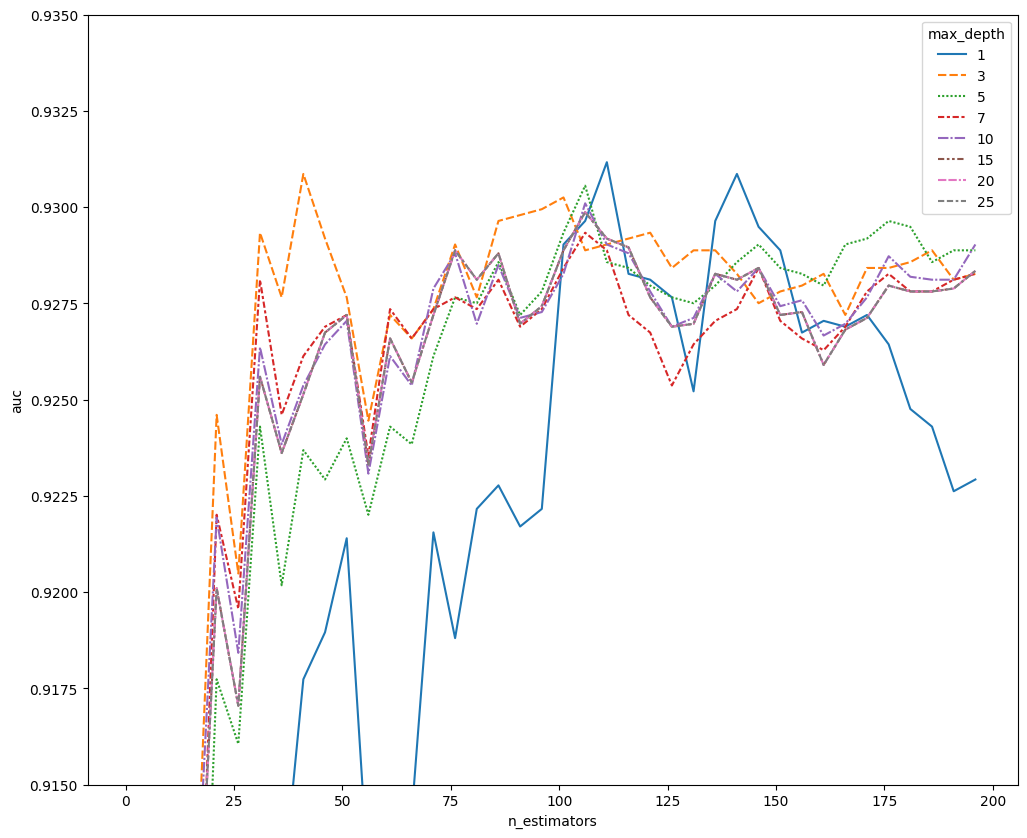

In [26]:
plt.figure(figsize=(12, 10))
sns.lineplot(
    data=rf_scores_val,
    x='n_estimators',
    y='auc',
    hue='max_depth',
    errorbar=None,
    style='max_depth',
)
plt.ylim(0.915, 0.935)


(0.91, 0.945)

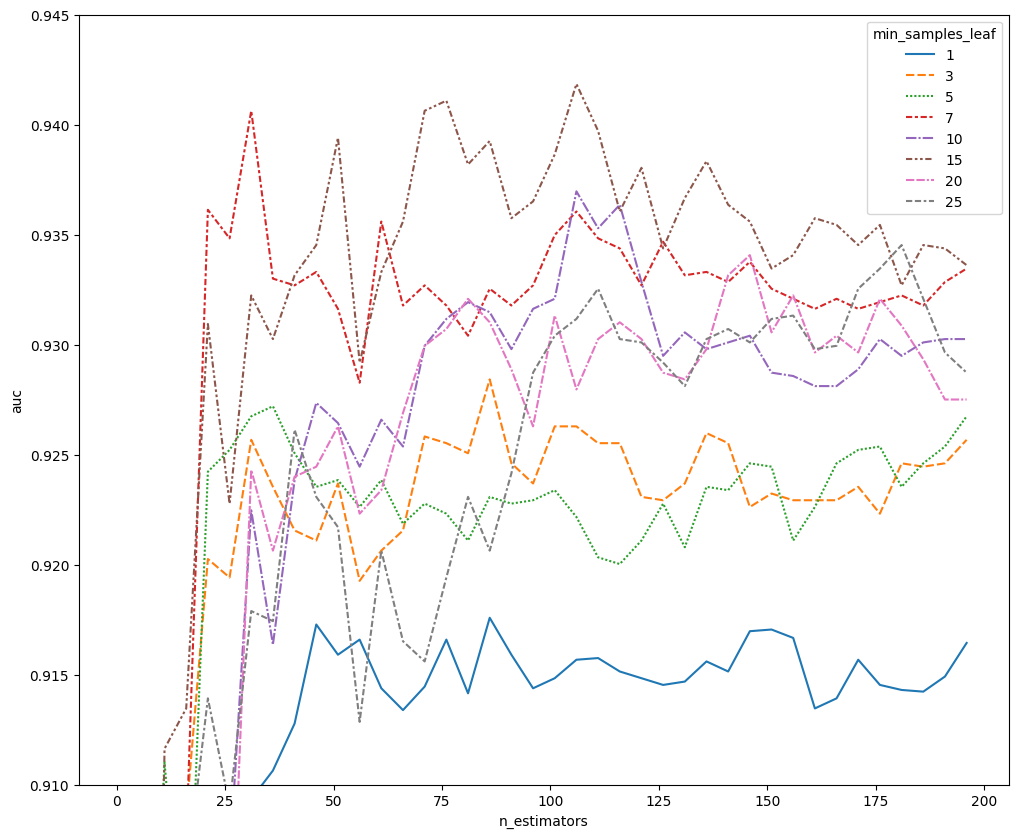

In [27]:
plt.figure(figsize=(12, 10))
sns.lineplot(
    data=rf_scores_val,
    x='n_estimators',
    y='auc',
    hue='min_samples_leaf',
    errorbar=None,
    style='min_samples_leaf',
)
plt.ylim(0.91, 0.945)


In [28]:
rf_scores_val.nlargest(30, ['auc', 'f1', 'accuracy', 'recall', 'precision'])

,n_estimators,max_depth,min_samples_leaf,accuracy,auc,precision,recall,f1
1071,76,3,15,0.850000,0.947497,0.875000,0.666667,0.756757
1061,51,3,15,0.850000,0.947497,0.928571,0.619048,0.742857
1069,71,3,15,0.833333,0.947497,0.866667,0.619048,0.722222
2173,31,7,7,0.866667,0.947497,0.842105,0.761905,0.800000
2813,31,10,7,0.866667,0.947497,0.842105,0.761905,0.800000
3453,31,15,7,0.866667,0.947497,0.842105,0.761905,0.800000
4093,31,20,7,0.866667,0.947497,0.842105,0.761905,0.800000
4733,31,25,7,0.866667,0.947497,0.842105,0.761905,0.800000
2169,21,7,7,0.833333,0.947497,0.823529,0.666667,0.736842
2171,26,7,7,0.866667,0.946276,0.842105,0.761905,0.800000


Choose n_estimators=51, max_depth=3, min_samples_leaf=15 as best parameter for random forest model. This one does not overfit.

,accuracy,auc,precision,recall,f1
"random_forest, n_estimators=51, max_depth=3, min_samples_leaf=15",0.85,0.947497,0.928571,0.619048,0.742857


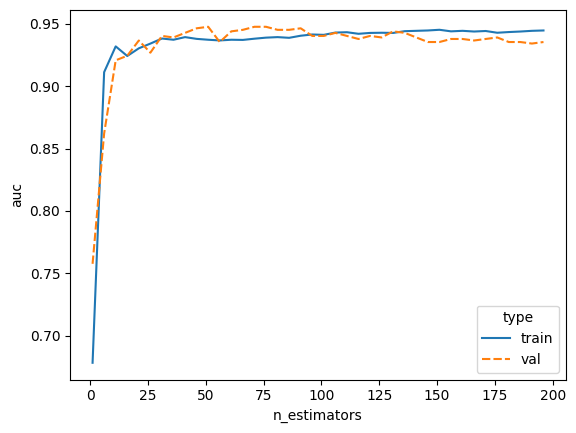

In [29]:
rf1 = rf_scores.query('max_depth==3 & min_samples_leaf==15')
sns.lineplot(data=rf1, x='n_estimators', y='auc', hue='type', style='type')
rf_result = rf1.query('type=="val"').nlargest(1, columns='auc')[
    ['accuracy', 'auc', 'precision', 'recall', 'f1']
]
rf_result.index = ['random_forest, n_estimators=51, max_depth=3, min_samples_leaf=15']
rf_result

<Axes: xlabel='n_estimators', ylabel='auc'>

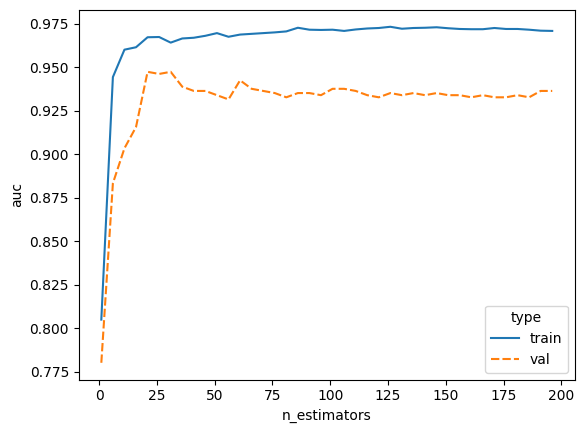

In [30]:
rf1 = rf_scores.query('max_depth==7 & min_samples_leaf==7')
sns.lineplot(data=rf1, x='n_estimators', y='auc', hue='type', style='type')

In [31]:
rf_scores_val.nlargest(30, ['f1', 'auc', 'accuracy', 'recall', 'precision'])


,n_estimators,max_depth,min_samples_leaf,accuracy,auc,precision,recall,f1
2567,16,10,1,0.900000,0.916361,0.894737,0.809524,0.850000
3207,16,15,1,0.900000,0.900488,0.894737,0.809524,0.850000
3847,16,20,1,0.900000,0.900488,0.894737,0.809524,0.850000
4487,16,25,1,0.900000,0.900488,0.894737,0.809524,0.850000
2671,76,10,3,0.883333,0.929182,0.850000,0.809524,0.829268
3311,76,15,3,0.883333,0.929182,0.850000,0.809524,0.829268
3951,76,20,3,0.883333,0.929182,0.850000,0.809524,0.829268
4591,76,25,3,0.883333,0.929182,0.850000,0.809524,0.829268
2719,196,10,3,0.883333,0.927961,0.850000,0.809524,0.829268
3359,196,15,3,0.883333,0.927961,0.850000,0.809524,0.829268


<Axes: xlabel='n_estimators', ylabel='auc'>

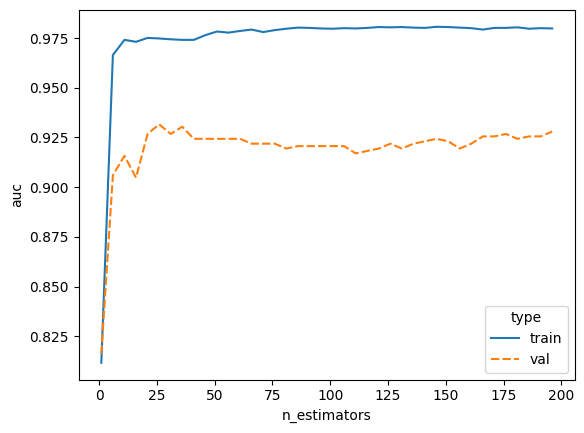

In [32]:
rf1 = rf_scores.query('max_depth==10 & min_samples_leaf==5')
sns.lineplot(data=rf1, x='n_estimators', y='auc', hue='type', style='type')


In [33]:
rf_scores_val.nlargest(30, ['accuracy', 'f1', 'auc', 'precision', 'recall'])


,n_estimators,max_depth,min_samples_leaf,accuracy,auc,precision,recall,f1
2567,16,10,1,0.900000,0.916361,0.894737,0.809524,0.850000
3207,16,15,1,0.900000,0.900488,0.894737,0.809524,0.850000
3847,16,20,1,0.900000,0.900488,0.894737,0.809524,0.850000
4487,16,25,1,0.900000,0.900488,0.894737,0.809524,0.850000
2671,76,10,3,0.883333,0.929182,0.850000,0.809524,0.829268
3311,76,15,3,0.883333,0.929182,0.850000,0.809524,0.829268
3951,76,20,3,0.883333,0.929182,0.850000,0.809524,0.829268
4591,76,25,3,0.883333,0.929182,0.850000,0.809524,0.829268
2719,196,10,3,0.883333,0.927961,0.850000,0.809524,0.829268
3359,196,15,3,0.883333,0.927961,0.850000,0.809524,0.829268


# xgboost

In [34]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)


In [75]:
result = {}
max_depths = [1, 3, 6, 10, 20, 30, 50, 100]
min_child_weights = [1, 5, 10, 20, 30, 50]
etas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1]

for eta in etas:
    for max_depth in max_depths:
        for min_child_weight in min_child_weights:
            xgb_params = {
                'eta': eta,
                'max_depth': max_depth,
                'min_child_weight': min_child_weight,
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'seed': 7,
                'verbosity': 1,
            }

            result[(eta, max_depth, min_child_weight)] = {}

            model = xgb.train(
                xgb_params,
                dtrain,
                num_boost_round=100,
                evals=[(dtrain, 'train'), (dval, 'val')],
                verbose_eval=False,
                evals_result=result[(eta, max_depth, min_child_weight)],
            )


In [76]:
xgb_scores = (
    pd.DataFrame(result.values(), index=result.keys())
    .stack()
    .apply(pd.Series)
    .explode('auc')
)

xgb_scores = xgb_scores.set_index(
    [
        xgb_scores.index,
        np.tile(range(100), len(etas) * len(min_child_weights) * len(max_depths) * 2),
    ]
).rename_axis(index=['eta', 'max_depth', 'min_child_weight', 'type', 'num_boost_round'])


xgb_scores['auc'] = xgb_scores['auc'].astype(float)
xgb_scores

auc
eta  max_depth min_child_weight type  num_boost_round          
0.01 1         1                train 0                0.783123
                                      1                0.783123
                                      2                0.783123
                                      3                0.783123
                                      4                0.783123
...                                                         ...
1.00 100       50               val   95               0.500000
                                      96               0.500000
                                      97               0.500000
                                      98               0.500000
                                      99               0.500000

[67200 rows x 1 columns]

In [ ]:
xgb_scores.query('type=="val"').nlargest(20, 'auc')

auc
eta max_depth min_child_weight type num_boost_round          
0.2 3         5                val  13               0.926740
1.0 6         1                val  3                0.925519
    10        1                val  3                0.925519
    20        1                val  3                0.925519
    30        1                val  3                0.925519
    50        1                val  3                0.925519
    100       1                val  3                0.925519
0.3 1         5                val  31               0.924908
0.5 1         10               val  9                0.924908
0.3 10        1                val  11               0.924298
    20        1                val  11               0.924298
    30        1                val  11               0.924298
    50        1                val  11               0.924298
    100       1                val  11               0.924298
0.5 1         10               val  5                0.924298
1.0 6         1                val  4                0.924298
    10        1                val  4                0.924298
    20        1                val  4                0.924298
    30        1                val  4                0.924298
    50        1                val  4                0.924298

<Axes: xlabel='num_boost_round', ylabel='auc'>

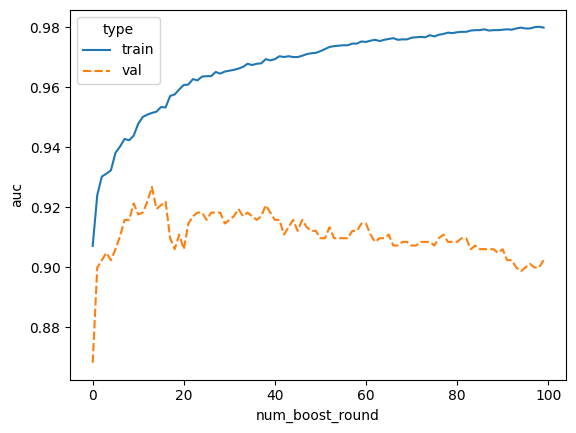

In [85]:
xgb1 = xgb_scores.query('eta==0.2 & max_depth==3 & min_child_weight==5')
sns.lineplot(data=xgb1, x='num_boost_round', y='auc', hue='type', style='type')

In [ ]:
xgb_result = xgb_scores.query('type=="val"').nlargest(1, 'auc')
xgb_result.index = xgb_result.index = [
    'xgboost,eta=0.2,max_depth=3,min_child_weight=5,num_boost_round=13'
]

xgb_result

,auc
"xgboost,eta=0.2,max_depth=3,min_child_weight=5,num_boost_round=13",0.92674


The best model is random forest, n_estimators=51, max_depth=3, min_samples_leaf=15

In [ ]:
pd.concat((lr_result, rf_result, xgb_result)).sort_values('auc', ascending=False)

,accuracy,auc,precision,recall,f1
"random_forest, n_estimators=51, max_depth=3, min_samples_leaf=15",0.850,0.947497,0.928571,0.619048,0.742857
"xgboost,eta=0.2,max_depth=3,min_child_weight=5,num_boost_round=13",NaN,0.926740,NaN,NaN,NaN
"logistic_regression, C=0.1",0.824,0.875000,0.837000,0.628000,0.704000


# Feature importance

In [122]:
rf_model = RandomForestClassifier(
    n_estimators=51, max_depth=3, min_samples_leaf=15, random_state=7, n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=15, n_estimators=51,
                       n_jobs=-1, random_state=7)

In [ ]:
feature_df = (
    pd.DataFrame(
        {'feature': dv.feature_names_, 'rf_importance': rf_model.feature_importances_}
    )
    .sort_values('rf_importance', ascending=False)
    .merge(logreg_feature_df, on='feature')
)

feature_df.insert(2, 'rf_rank', range(1, len(feature_df) + 1))
feature_df

,feature,rf_importance,rf_rank,logreg_coef,logreg_rank
0,time,0.342011,1,-0.965273,1
1,serum_creatinine,0.249785,2,0.541427,3
2,ejection_fraction,0.180786,3,-0.571806,2
3,age,0.116051,4,0.410151,4
4,serum_sodium,0.054990,5,-0.151043,5
5,creatinine_phosphokinase,0.018388,6,-0.104251,7
6,platelets,0.012011,7,-0.075902,12
7,high_blood_pressure,0.009308,8,-0.091672,9
8,sex=woman,0.006098,9,0.091553,11
9,sex=man,0.003865,10,-0.091553,10
